# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [2]:
pip install -r requirements.txt


In [4]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import json
from pathlib import Path

## Session Management

Save/load your session to avoid re-registering.

In [5]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [6]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

No saved session. Register below.


## Step 1: Register

Skip this if you resumed a session above.

In [8]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()

    # CHANGE THESE to your unique values
    PLAYER_ID = "asingh"
    PLAYER_NAME = "archana"

    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())

    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

remote or in_person: in_person
Registered! Token: 1XTsG5TCcTcmOcAo6tvO...

Starting candidates (4):
  - Honolulu, HI: 3 qubits, +1 bonus
  - Irvine, CA: 2 qubits, +2 bonus
  - Rio de Janeiro, Brazil: 5 qubits, +1 bonus
  - Riverside, CA: 2 qubits, +2 bonus
Session saved.


## Step 2: Select Starting Node

In [15]:
status = client.get_status()
client.print_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Riverside, CA")
    print(result)

Player: asingh (archana)
Score: 0 | Budget: 75 bell pairs
Active: Yes
Starting node: None
Owned: 0 nodes, 0 edges
Claimable edges: 0
Select a starting node from the candidates shown above.
{'ok': True, 'data': {'success': True, 'starting_node': 'Riverside, CA', 'score': 0, 'budget': 77}}


## Step 3: Explore the Network

In [17]:
client.print_status()

Player: asingh (archana)
Score: 0 | Budget: 77 bell pairs
Active: Yes
Starting node: Riverside, CA
Owned: 1 nodes, 0 edges
Claimable edges: 5
  - ['Los Angeles, CA', 'Riverside, CA']: threshold=0.90, difficulty=1
  - ['Las Vegas, NV', 'Riverside, CA']: threshold=0.90, difficulty=2
  - ['Pasadena, CA', 'Riverside, CA']: threshold=0.90, difficulty=1
  ... and 2 more


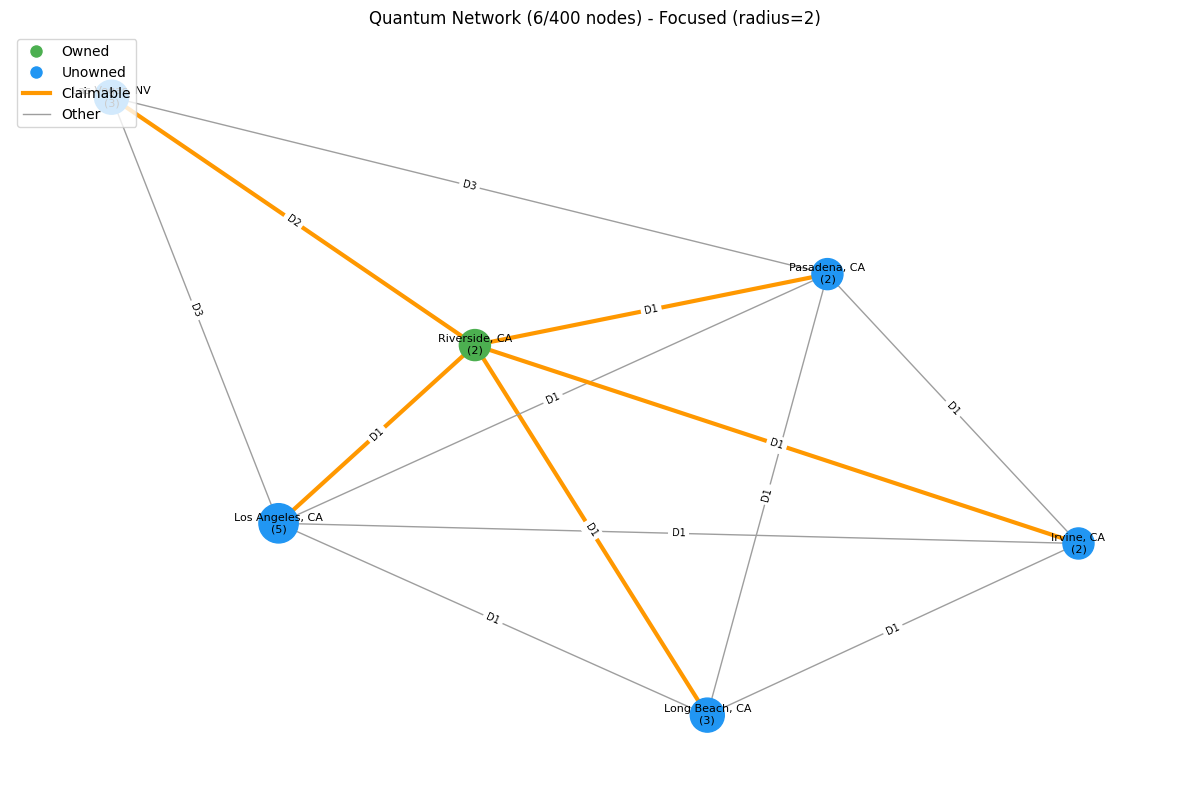

In [18]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

In [120]:
def create_distillation_circuit():
    """Example distillation circuit template for 2 Bell pairs."""
    qr = QuantumRegister(4, 'q')  # 4 qubits for 2 Bell pairs
    cr = ClassicalRegister(2, 'c')  # Classical bits for measurements + flag
    qc = QuantumCircuit(qr, cr)

    # TODO: Add your distillation operations here
    # Qubit layout for N=2:
    #   q0, q3: Ancilla pair (to be measured)
    #   q1, q2: Data pair (output)
    """
    Simple 2→1 BBPSSW-style distillation
    """
    # Extract syndrome: measure ancilla parity
    qc.cx(0, 3)
    qc.measure(3, 0)  # syndrome[0] = parity

    # # Conditional operations using if_test
    # with qc.if_test((cr[0], 1)):  # If syndrome bit = 1
    #     qc.x(3)  # Reset q3
    #     qc.z(1)  # Apply phase correction to data
    #     qc.z(2)

    # Your standard CNOTs
   # Extract syndrome: measure ancilla parity
    qc.cx(0, 3)
    qc.measure(3, 0)  # syndrome[0] = parity

    # Conditional operations using if_test
    with qc.if_test((cr[0], 1)):  # If syndrome bit = 1
        qc.x(3)  # Reset q3
        qc.z(1)  # Apply phase correction to data
        qc.z(2)

    # Your standard CNOTs
    qc.cx(1, 0)
    qc.cx(2, 3)

    # Adaptive measurement basis
    with qc.if_test((cr[0], 1)):  # If syndrome detected
        qc.ry(np.pi/4, 0)  # Diagonal basis
        qc.ry(np.pi/4, 3)

    # Final measurement
    qc.measure([0, 3], [0, 1])
    # # Adaptive measurement basis
    # with qc.if_test((cr[0], 1)):  # If syndrome detected
    #     qc.ry(np.pi/4, 0)  # Diagonal basis
    #     qc.ry(np.pi/4, 3)

    # Final measurement
    qc.measure([0, 3], [0, 1])
    # qc.measure([0, 3], [0, 1])
    # -----------------------------
    # # Standard BBPSSW
    # qc.cx(1, 0)
    # qc.cx(2, 3)
    # # Add Hadamard for phase-error robustness

    # qc.measure([0, 3], [0, 1])
    # ------------

    # # Controlled-Phase instead of CNOT (better for phase errors)
    # qc.h(1)
    # qc.cz(0, 1)
    # qc.h(1)

    # qc.h(2)
    # qc.cz(3, 2)
    # qc.h(2)

    # # Measure in rotated basis (45° between Z and X)
    # qc.ry(np.pi/4, 0)
    # qc.ry(np.pi/4, 3)
    # qc.measure([0, 3], [0, 1])

    return qc


    # return qc

circuit = create_distillation_circuit()
print(circuit.draw(output='text'))

                                               ┌───┐  ┌──────  ┌─────────┐»
q_0: ──■───────■───────────────────────────────┤ X ├──┤       ─┤ Ry(π/4) ├»
       │       │       ┌──────  ┌───┐ ───────┐ └─┬─┘  │        └─────────┘»
q_1: ──┼───────┼───────┤       ─┤ Z ├        ├───■────┤       ────────────»
       │       │       │        ├───┤        │        │ If-0              »
q_2: ──┼───────┼───────┤ If-0  ─┤ Z ├  End-0 ├───■────┤       ────────────»
     ┌─┴─┐┌─┐┌─┴─┐┌─┐  │        ├───┤        │ ┌─┴─┐  │        ┌─────────┐»
q_3: ┤ X ├┤M├┤ X ├┤M├──┤       ─┤ X ├        ├─┤ X ├──┤       ─┤ Ry(π/4) ├»
     └───┘└╥┘└───┘└╥┘  └──╥───  └───┘ ───────┘ └───┘  └──╥───  └─────────┘»
           ║       ║ ┌────╨────┐                    ┌────╨────┐           »
c: 2/══════╩═══════╩═╡ c_0=0x1 ╞════════════════════╡ c_0=0x1 ╞═══════════»
           0       0 └─────────┘                    └─────────┘           »
«      ───────┐ ┌─┐   ┌─┐   
«q_0:         ├─┤M├───┤M├───
«             │ └╥┘   └╥┘   
«

In [23]:
pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 78.4 MB/s eta 0:00:00


In [24]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, phase_damping_error
import numpy as np

QiskitError: 'No counts for experiment "0"'

In [62]:
def cascaded_distillation(num_rounds=2):
    """
    Apply distillation multiple times.
    Each round improves fidelity but costs more pairs.

    Cost: 2^num_rounds input pairs → 1 output pair
    """
    qr = QuantumRegister(4 * num_rounds, 'q')
    cr = ClassicalRegister(2 * num_rounds, 'c')
    qc = QuantumCircuit(qr, cr)

    for round_idx in range(num_rounds):
        offset = round_idx * 4

        # BBPSSW distillation
        qc.cx(offset + 0, offset + 1)  # Alice
        qc.cx(offset + 3, offset + 2)  # Bob
        qc.measure([offset + 0, offset + 3], [round_idx * 2, round_idx * 2 + 1])

        # Output q1-q2 becomes input for next round
        # (in practice, you'd use the purified pair as input to new circuit)

    return qc

# Resource cost for F=0.85 → 0.90:
# Round 1: 2 pairs → F ≈ 0.9864
# Already exceeds 0.90! ✓

## Step 5: Claim an Edge

In [121]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:5]:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (5):
  ['Los Angeles, CA', 'Riverside, CA'] - threshold: 0.900, difficulty: 1
  ['Pasadena, CA', 'Riverside, CA'] - threshold: 0.900, difficulty: 1
  ['Irvine, CA', 'Riverside, CA'] - threshold: 0.900, difficulty: 1
  ['Long Beach, CA', 'Riverside, CA'] - threshold: 0.900, difficulty: 1
  ['Las Vegas, NV', 'Riverside, CA'] - threshold: 0.900, difficulty: 2


In [122]:
# Claim an edge
if claimable:
    target = claimable_sorted[0]  # Easiest edge
    edge_id = tuple(target['edge_id'])

    circuit = create_distillation_circuit()
    num_bell_pairs = 2
    flag_bit = 0  # Classical bit for post-selection (keep when flag=0)

    print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")

    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)

    if result.get("ok"):
        data = result["data"]
        print(f"Success: {data.get('success')}")
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print(f"Error: {result.get('error', {}).get('message')}")

Claiming ('Los Angeles, CA', 'Riverside, CA') (threshold: 0.900)...


HTTPError: 400 Client Error: Bad Request for url: https://demo-entanglement-distillation-qfhvrahfcq-uc.a.run.app/v1/claim_edge

## Step 6: Check Progress

In [61]:
client.print_status()

Player: asingh (archana)
Score: 0 | Budget: 77 bell pairs
Active: Yes
Starting node: Riverside, CA
Owned: 1 nodes, 0 edges
Claimable edges: 5
  - ['Los Angeles, CA', 'Riverside, CA']: threshold=0.90, difficulty=1
  - ['Las Vegas, NV', 'Riverside, CA']: threshold=0.90, difficulty=2
  - ['Pasadena, CA', 'Riverside, CA']: threshold=0.90, difficulty=1
  ... and 2 more


In [ ]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

Leaderboard:
1. your_unique_id       Score: 0


## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [ ]:
# Restart game (uncomment to use)
# result = client.restart()
# print(result)